Dispositivo: cpu

Carregando dataset IMDB...
Dataset carregado: 50000 exemplos
Distribuição: {1: 25000, 0: 25000}

Iniciando validação cruzada 3-fold...


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]


# Fold 1/3
  - Treino: 4333 exemplos
  - Validação: 2167 exemplos


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Treinando fold 1...


Step,Training Loss
50,0.618000
100,0.458600
150,0.364600
200,0.412800
250,0.395800
300,0.276000
350,0.231100
400,0.195700
450,0.213700
500,0.175200


Avaliando fold 1...


  @ Resultados do Fold 1:
    eval_loss: 0.4285
    eval_accuracy: 0.8629
    eval_precision: 0.8331
    eval_recall: 0.9114
    eval_f1: 0.8705
    eval_runtime: 878.8985
    eval_samples_per_second: 2.4660
    eval_steps_per_second: 0.0770
    epoch: 2.0000


<Figure size 600x500 with 0 Axes>

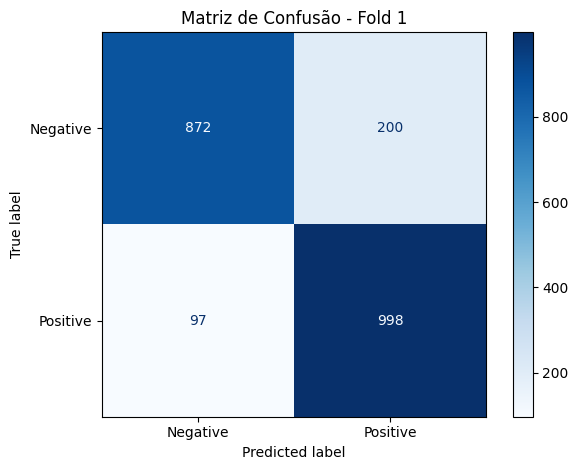


# Fold 2/3
  - Treino: 4333 exemplos
  - Validação: 2167 exemplos


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Treinando fold 2...


Step,Training Loss
50,0.578300
100,0.429400
150,0.436300
200,0.369700
250,0.323800
300,0.226500
350,0.192600
400,0.241900
450,0.195700
500,0.204200


Avaliando fold 2...


  @ Resultados do Fold 2:
    eval_loss: 0.3574
    eval_accuracy: 0.8763
    eval_precision: 0.8749
    eval_recall: 0.8781
    eval_f1: 0.8765
    eval_runtime: 880.8132
    eval_samples_per_second: 2.4600
    eval_steps_per_second: 0.0770
    epoch: 2.0000


<Figure size 600x500 with 0 Axes>

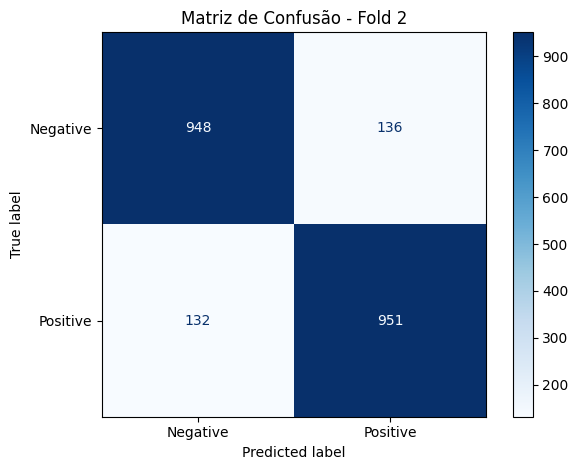


# Fold 3/3
  - Treino: 4334 exemplos
  - Validação: 2166 exemplos


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


Treinando fold 3...


Step,Training Loss
50,0.648200
100,0.442300
150,0.382700
200,0.387800
250,0.366600
300,0.233800
350,0.186100
400,0.219700
450,0.192100
500,0.192300


Avaliando fold 3...


  @ Resultados do Fold 3:
    eval_loss: 0.4391
    eval_accuracy: 0.8657
    eval_precision: 0.8690
    eval_recall: 0.8666
    eval_f1: 0.8678
    eval_runtime: 898.4154
    eval_samples_per_second: 2.4110
    eval_steps_per_second: 0.0760
    epoch: 2.0000


<Figure size 600x500 with 0 Axes>

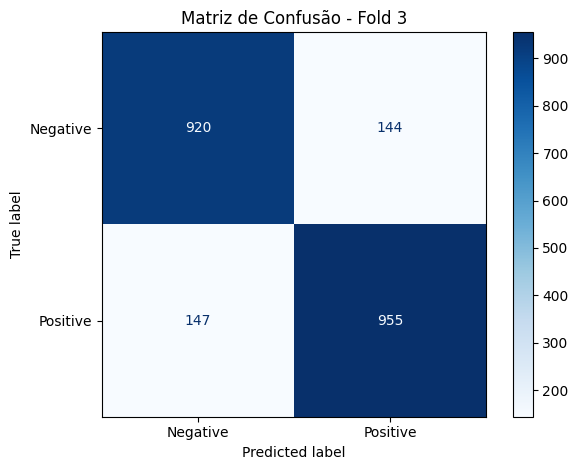


# RESULTADOS DA VALIDAÇÃO CRUZADA
ACCURACY : 0.8683 ± 0.0058
PRECISION: 0.8590 ± 0.0185
RECALL   : 0.8854 ± 0.0190
F1-SCORE : 0.8716 ± 0.0036

@ Resultados por fold:
  Fold 1: Accuracy=0.8629, F1-Score=0.8705
  Fold 2: Accuracy=0.8763, F1-Score=0.8765
  Fold 3: Accuracy=0.8657, F1-Score=0.8678


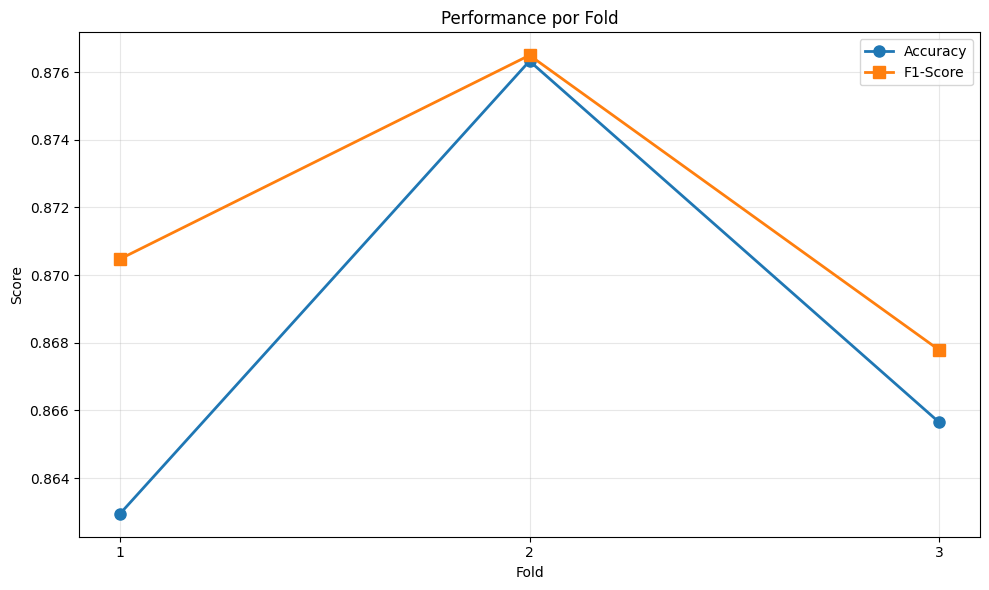


Validação cruzada concluída!
Accuracy média: 0.8683


In [ ]:
# -*- coding: utf-8 -*-
"""
BERT IMDB sentiment classification - Versão compatível com transformers antigos
"""

import os
import random
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    accuracy_score,
    precision_recall_fscore_support,
)
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    Trainer,
    TrainingArguments,
)
import kagglehub

os.environ["WANDB_DISABLED"] = "true"

# ────────────────────────────────────────────────────────────────────────────────
# 1. Configuração
# ────────────────────────────────────────────────────────────────────────────────
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

# Configuração do ambiente
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Dispositivo: {device}")

# ────────────────────────────────────────────────────────────────────────────────
# 2. Carregar dados
# ────────────────────────────────────────────────────────────────────────────────
print("\nCarregando dataset IMDB...")
path = kagglehub.dataset_download("lakshmi25npathi/imdb-dataset-of-50k-movie-reviews")
csv_path = os.path.join(path, "IMDB Dataset.csv")

df = pd.read_csv(csv_path)
print(f"Dataset carregado: {len(df)} exemplos")

# Mapear labels
df["label"] = df["sentiment"].apply(lambda x: 1 if x == "positive" else 0)
print(f"Distribuição: {df['label'].value_counts().to_dict()}")

df = df.sample(n=6500, random_state=SEED)
print(f"Usando {len(df)} exemplos para teste")

# ────────────────────────────────────────────────────────────────────────────────
# 3. Dataset personalizado PyTorch
# ────────────────────────────────────────────────────────────────────────────────
class IMDBDataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# ────────────────────────────────────────────────────────────────────────────────
# 4. Função de métricas compatível
# ────────────────────────────────────────────────────────────────────────────────
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    precision, recall, f1, _ = precision_recall_fscore_support(
        labels, preds, average="binary", zero_division=0
    )
    acc = accuracy_score(labels, preds)

    return {
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "f1": f1,
    }

# ────────────────────────────────────────────────────────────────────────────────
# 5. Função de treinamento manual
# ────────────────────────────────────────────────────────────────────────────────
def train_and_evaluate(train_dataset, val_dataset, fold_num):
    """Treinamento e avaliação manual"""

    # Modelo
    model = BertForSequenceClassification.from_pretrained(
        "bert-base-uncased",
        num_labels=2
    )
    model.to(device)

    # Argumentos mínimos para compatibilidade
    training_args = TrainingArguments(
        output_dir=f"./results_fold_{fold_num}",
        num_train_epochs=2,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=32,
        logging_steps=50,
        save_steps=10000,
        seed=SEED,
        dataloader_num_workers=0,
    )

    # Trainer básico
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=compute_metrics,
    )

    # Treinamento
    print(f"Treinando fold {fold_num}...")
    trainer.train()

    # Avaliação
    print(f"Avaliando fold {fold_num}...")
    eval_results = trainer.evaluate()

    # Predições para matriz de confusão
    predictions = trainer.predict(val_dataset)
    y_true = predictions.label_ids
    y_pred = np.argmax(predictions.predictions, axis=1)

    return eval_results, y_true, y_pred, trainer

# ────────────────────────────────────────────────────────────────────────────────
# 6. Cross-validation
# ────────────────────────────────────────────────────────────────────────────────
print("\nIniciando validação cruzada 3-fold...")

# Preparar dados
texts = df["review"].tolist()
labels = df["label"].tolist()

# Tokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

# K-Fold
kf = KFold(n_splits=3, shuffle=True, random_state=SEED)
all_metrics = []
confusion_matrices = []

for fold, (train_idx, val_idx) in enumerate(kf.split(texts)):
    print(f"\n# Fold {fold + 1}/3")

    # Dividir dados
    train_texts = [texts[i] for i in train_idx]
    train_labels = [labels[i] for i in train_idx]
    val_texts = [texts[i] for i in val_idx]
    val_labels = [labels[i] for i in val_idx]

    print(f"  - Treino: {len(train_texts)} exemplos")
    print(f"  - Validação: {len(val_texts)} exemplos")

    # Criar datasets
    train_dataset = IMDBDataset(train_texts, train_labels, tokenizer)
    val_dataset = IMDBDataset(val_texts, val_labels, tokenizer)

    try:
        # Treinar e avaliar
        metrics, y_true, y_pred, trainer = train_and_evaluate(
            train_dataset, val_dataset, fold + 1
        )

        all_metrics.append(metrics)
        confusion_matrices.append((y_true, y_pred))

        print(f"  @ Resultados do Fold {fold+1}:")
        for key, value in metrics.items():
            print(f"    {key}: {value:.4f}")

        # Matriz de confusão
        cm = confusion_matrix(y_true, y_pred)
        disp = ConfusionMatrixDisplay(
            confusion_matrix=cm,
            display_labels=["Negative", "Positive"]
        )

        plt.figure(figsize=(6, 5))
        disp.plot(cmap='Blues')
        plt.title(f"Matriz de Confusão - Fold {fold + 1}")
        plt.tight_layout()
        plt.show()

        # Limpar memória
        del trainer
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

    except Exception as e:
        print(f"  Erro no fold {fold + 1}: {str(e)}")
        import traceback
        traceback.print_exc()
        continue

# ────────────────────────────────────────────────────────────────────────────────
# 7. Resultados finais
# ────────────────────────────────────────────────────────────────────────────────
if all_metrics:
    print("\n" + "="*60)
    print("# RESULTADOS DA VALIDAÇÃO CRUZADA")
    print("="*60)

    # Extrair métricas
    accuracies = [m.get('eval_accuracy', m.get('accuracy', 0)) for m in all_metrics]
    precisions = [m.get('eval_precision', m.get('precision', 0)) for m in all_metrics]
    recalls = [m.get('eval_recall', m.get('recall', 0)) for m in all_metrics]
    f1s = [m.get('eval_f1', m.get('f1', 0)) for m in all_metrics]

    # Calcular médias
    print(f"ACCURACY : {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
    print(f"PRECISION: {np.mean(precisions):.4f} ± {np.std(precisions):.4f}")
    print(f"RECALL   : {np.mean(recalls):.4f} ± {np.std(recalls):.4f}")
    print(f"F1-SCORE : {np.mean(f1s):.4f} ± {np.std(f1s):.4f}")

    # Resultados por fold
    print(f"\n@ Resultados por fold:")
    for i, acc in enumerate(accuracies):
        print(f"  Fold {i+1}: Accuracy={acc:.4f}, F1-Score={f1s[i]:.4f}")

    # Gráfico final
    plt.figure(figsize=(10, 6))
    x = range(1, len(accuracies) + 1)
    plt.plot(x, accuracies, 'o-', label='Accuracy', linewidth=2, markersize=8)
    plt.plot(x, f1s, 's-', label='F1-Score', linewidth=2, markersize=8)

    plt.xlabel('Fold')
    plt.ylabel('Score')
    plt.title('Performance por Fold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.xticks(x)
    plt.tight_layout()
    plt.show()

    print(f"\nValidação cruzada concluída!")
    print(f"Accuracy média: {np.mean(accuracies):.4f}")

else:
    print("\nNenhum fold foi concluído com sucesso.")